In [1]:
import os
import tensorflow as tf

import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_ubyte
from sklearn import preprocessing

In [2]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
orion_image = load_img('structure7.jpg')
#orion_image = tf.reshape(orion_image, (402, 512, 3))
milky_way_image = load_img('Color Milky Way.jpg')
#milky_way_image = tf.reshape(milky_way_image, (256, 512, 3))

In [4]:
print(orion_image.shape)
print(milky_way_image.shape)

milky_way_grid = {}
for i in range(8):
    for j in range(8):
        milky_way_subsection = milky_way_image[:, i*32:(i+1)*32, j*64:(j+1)*64, :]
        milky_way_grid[str(i)+str(j)] = milky_way_subsection
        #print(milky_way_subsection.shape)

(1, 269, 512, 3)
(1, 256, 512, 3)


In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [6]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [7]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [8]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [9]:
style_extractor = vgg_layers(style_layers)
#style_outputs = style_extractor(style_image*255)
#style_outputs = []
gram_dict = {}
for i in range(8):
    for j in range(8):
        style_outputs = style_extractor(milky_way_grid[str(i)+str(j)]*255)
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        gram_dict[str(i)+str(j)] = style_outputs

In [10]:
orion_style_output = [gram_matrix(style_output) for style_output in style_extractor(orion_image*255)]
gram_dict['Orion'] = orion_style_output

In [11]:
#Testing with orion data
dot_product_matrix = np.zeros((8, 8))
norm_product_matrix = np.zeros((8, 8))
norm_to_dot_product_matrix = np.zeros((8, 8))
mse_matrix = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        milky_gram = gram_dict[str(i)+str(j)][4].numpy().flatten()
        orion_gram = gram_dict['Orion'][4].numpy().flatten()
        
        dot_product_matrix[i][j] = np.dot(milky_gram, orion_gram)
        norm_product_matrix[i][j] = np.linalg.norm(milky_gram)*np.linalg.norm(orion_gram)
        norm_to_dot_product_matrix[i][j] = dot_product_matrix[i][j]/norm_product_matrix[i][j]
        mse_matrix[i][j] = (np.square(milky_gram - orion_gram)).mean(axis=None)

In [12]:
#print(norm_to_dot_product_matrix)
#print(mse_matrix)

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
norm_dot_ratio_rescaled = min_max_scaler.fit_transform(norm_to_dot_product_matrix)
#print(norm_dot_ratio_rescaled)

In [13]:
milky_way_similarity_rescale = milky_way_image.numpy()

for i in range(8):
    for j in range(8):
        milky_way_similarity_rescale[:, i*32:(i+1)*32, j*64:(j+1)*64, :] = milky_way_similarity_rescale[:, i*32:(i+1)*32, j*64:(j+1)*64, :] * norm_dot_ratio_rescaled[i][j]

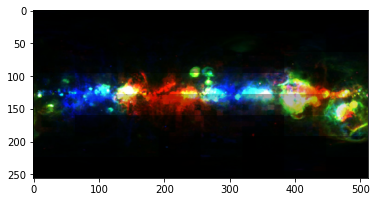

In [14]:
milky_way_similarity_rescale = np.reshape(milky_way_similarity_rescale, (256, 512, 3))
imgplot = plt.imshow(milky_way_similarity_rescale)

Text(0.5, 0.98, 'Heatmap for 32x64 pixel groups')

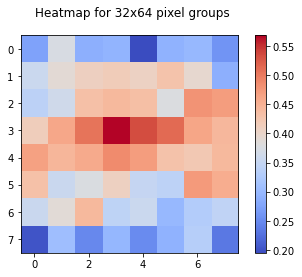

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(norm_to_dot_product_matrix, cmap='coolwarm')
fig.colorbar(im, ax=ax)
fig.suptitle('Heatmap for 32x64 pixel groups')

# plt.imshow(norm_to_dot_product_matrix)
# plt.title = '32x64 pixel heatmap'
# plt.show()